In [ ]:
# monto il drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importo il df
import pandas as pd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
dfOk = pd.read_csv('/content/drive/MyDrive/dm1Progetto/dataset/datasetCopiaSUPEROK.csv')
df = dfOk.copy()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

def engineer_player_features(df):
    """Player count features"""
    df["RangePlayers"] = df["MaxPlayers"] - df["MinPlayers"]
    df["IsSoloPlayable"] = (df["MinPlayers"] == 1).astype(int)
    df["IsPartySize"] = (df["MaxPlayers"] >= 8).astype(int)
    return df

def engineer_playtime_features(df):
    """Playtime consistency"""
    df["PlaytimeRange"] = df["ComMaxPlaytime"] - df["ComMinPlaytime"]
    return df

def engineer_popularity_features(df):
    """Popularity-based features"""
    df["DemandRatio"] = df["NumWant"] / (df["NumOwned"] + 1)
    df["OwnershipRatio"] = df["NumOwned"] / (df["NumOwned"] + df["NumWant"] + 1)
    return df

def engineer_category_features(df):
    """Count number of categories"""
    cat_cols = [
        'Cat:Thematic','Cat:Strategy','Cat:War','Cat:Family',
        'Cat:CGS','Cat:Abstract','Cat:Party','Cat:Childrens'
    ]
    df["NumCategories"] = df[cat_cols].sum(axis=1)
    return df

def engineer_rank_features(df):
    """Ranking features: BestRank, AvgRank, RankSpread"""

    rank_cols = [
        'Rank:strategygames','Rank:abstracts','Rank:familygames',
        'Rank:thematic','Rank:cgs','Rank:wargames',
        'Rank:partygames','Rank:childrensgames'
    ]

    # Step 1 — 21926 = "missing", convert to NaN
    df[rank_cols] = df[rank_cols].replace(21926, np.nan)

    # Step 2 — BestRank: se tutte NaN → usa un valore neutro (es. 25000 o NaN)
    df["BestRank"] = df[rank_cols].fillna(25000).min(axis=1)

    # Step 3 — AvgRank: media dei valori REALI, ignorando NaN
    #df["AvgRank"] = df[rank_cols].mean(axis=1)

    # Step 4 — Spread: differenza tra valori validi
    #df["RankSpread"] = df[rank_cols].max(axis=1) - df[rank_cols].min(axis=1)

    return df


def engineer_rankCluster(df):
    # 1. Selezione feature
    X = df[["NumOwned", "NumWant", "GameWeight", "PlaytimeRange"]]

    # 2. Standardizzazione
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # 3. KMeans clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    df["Cluster"] = kmeans.fit_predict(X_scaled)

    # 4. Ordina cluster per popolarità media
    cluster_order = df.groupby("Cluster")["NumOwned"].mean().sort_values(ascending=False).index

    # 5. Mappa cluster → rank
    mapping = {cluster: rank+1 for rank, cluster in enumerate(cluster_order)}
    df["RankArtificial"] = df["Cluster"].map(mapping)

    return df

def engineer_artificial_score(df, weights=None, features=None, ascending=False):
    """
    Artificial Score & RankScore based on a weighted linear combination of features.

    Parametri:
    - df: DataFrame dei giochi
    - weights: dict feature -> peso
               Se None, usa pesi di default
    - features: lista delle feature da usare.
                Se None usa le key di weights
    - ascending: True → rank basso = migliore,
                 False → rank alto = migliore

    Output:
    - df con colonne:
        • Score
        • RankScore
    """

    # 1. Default weights
    if weights is None:
        weights = {
            "NumOwned": 0.4,
            "NumWant": 0.2,
            "NumWeightVotes": 0.2,
            "GameWeight": 0.1,
            "PlaytimeRange": -0.1
        }

    # 2. Default feature list
    if features is None:
        features = list(weights.keys())

    # 3. Compute weighted score
    df["Score"] = sum(df[f] * weights[f] for f in features)

    # 4. Rank computed score
    df["RankScore"] = df["Score"].rank(ascending=ascending)

    return df



def apply_all_feature_engineering(df):
    """Apply all FE steps in correct order"""
    df = engineer_player_features(df)
    df = engineer_playtime_features(df)
    df = engineer_popularity_features(df)
    df = engineer_category_features(df)
    df = engineer_rank_features(df)
    df = engineer_rankCluster(df)
    df = engineer_artificial_score(df)
    return df

In [ ]:
df = apply_all_feature_engineering(df)

In [ ]:
df.columns.to_list()

['BGGId',
 'Name',
 'Description',
 'YearPublished',
 'GameWeight',
 'MinPlayers',
 'MaxPlayers',
 'ComAgeRec',
 'LanguageEase',
 'BestPlayers',
 'GoodPlayers',
 'NumOwned',
 'NumWant',
 'NumWeightVotes',
 'ComMinPlaytime',
 'ComMaxPlaytime',
 'MfgAgeRec',
 'NumAlternates',
 'NumExpansions',
 'NumImplementations',
 'IsReimplementation',
 'Kickstarted',
 'Rank:strategygames',
 'Rank:abstracts',
 'Rank:familygames',
 'Rank:thematic',
 'Rank:cgs',
 'Rank:wargames',
 'Rank:partygames',
 'Rank:childrensgames',
 'Cat:Thematic',
 'Cat:Strategy',
 'Cat:War',
 'Cat:Family',
 'Cat:CGS',
 'Cat:Abstract',
 'Cat:Party',
 'Cat:Childrens',
 'Rating',
 'LanguageEase_log']

In [ ]:
import pandas as pd
import numpy as np


df['YearPublished_disc'] = pd.cut(
    df['YearPublished'],
    bins=[-np.inf, 1989, 1999, 2009, 2019, np.inf],
    labels=['<1990','1990s','2000s','2010s','2020s']
)


df['GameWeight_disc'] = pd.cut(
    df['GameWeight'],
    bins=[-0.1, 1.5, 2.5, 5],
    labels=['Light','Medium','Heavy']
)

df['MinPlayers_disc'] = pd.cut(
    df['MinPlayers'],
    bins=[-0.1,1,2,4,10],
    labels=['Solo','Few','Medium','Many']
)

df['MaxPlayers_disc'] = pd.cut(
    df['MaxPlayers'],
    bins=[1,4,6,10,21],
    labels=['Small','Medium','Large','VeryLarge']
)

df['ComAgeRec_disc'] = pd.cut(
    df['ComAgeRec'],
    bins=[0,6,12,18,25],
    labels=['Child','Teen','YoungAdult','Adult']
)

df['NumOwned_log'] = np.log1p(df['NumOwned'])
df['NumOwned_disc'] = pd.qcut(df['NumOwned_log'], q=4, labels=['Low','Medium','High','VeryHigh'])

df['NumWant_log'] = np.log1p(df['NumWant'])
df['NumWant_disc'] = pd.qcut(df['NumWant_log'], q=4, labels=['Low','Medium','High','VeryHigh'])

df['NumWeightVotes_log'] = np.log1p(df['NumWeightVotes'])
df['NumWeightVotes_disc'] = pd.qcut(df['NumWeightVotes_log'], q=4, labels=['Low','Medium','High','VeryHigh'])

df['ComMinPlaytime_disc'] = pd.qcut(df['ComMinPlaytime'], q=4, labels=['VeryShort','Short','Medium','Long'])

df['ComMaxPlaytime_disc'] = pd.qcut(df['ComMaxPlaytime'], q=4, labels=['VeryShort','Short','Medium','Long'])

rating_map = {'Low':'Low','Medium':'Medium','High':'High'}
df['Rating_disc'] = df['Rating'].map(rating_map)

df = df.drop(columns=['NumOwned_log','NumWant_log','NumWeightVotes_log'])

print(df[['YearPublished_disc','GameWeight_disc','MinPlayers_disc','MaxPlayers_disc',
          'ComAgeRec_disc','NumOwned_disc','NumWant_disc','NumWeightVotes_disc',
          'ComMinPlaytime_disc','ComMaxPlaytime_disc','Rating_disc']].head())


  YearPublished_disc GameWeight_disc MinPlayers_disc MaxPlayers_disc  \
0              2010s          Medium             Few           Small   
1              2020s           Light             Few          Medium   
2              2020s           Heavy            Solo          Medium   
3              2000s           Light             Few           Small   
4              2010s           Light             Few           Small   

  ComAgeRec_disc NumOwned_disc NumWant_disc NumWeightVotes_disc  \
0           Teen          High       Medium              Medium   
1           Teen           Low         High              Medium   
2           Teen          High     VeryHigh              Medium   
3           Teen        Medium          Low                High   
4           Teen        Medium       Medium                 Low   

  ComMinPlaytime_disc ComMaxPlaytime_disc Rating_disc  
0               Short           VeryShort         Low  
1           VeryShort           VeryShort      Mediu

In [ ]:
features_pm = [
 'YearPublished_disc',
 'GameWeight_disc',
 'MinPlayers_disc',
 'MaxPlayers_disc',
 'ComAgeRec_disc',
 'NumOwned_disc',
 'NumWant_disc',
 'NumWeightVotes_disc',
 'ComMinPlaytime_disc',
 'ComMaxPlaytime_disc',
 'Rating_disc'
]

df = df[features_pm]

print(df.head())

  YearPublished_disc GameWeight_disc MinPlayers_disc MaxPlayers_disc  \
0              2010s          Medium             Few           Small   
1              2020s           Light             Few          Medium   
2              2020s           Heavy            Solo          Medium   
3              2000s           Light             Few           Small   
4              2010s           Light             Few           Small   

  ComAgeRec_disc NumOwned_disc NumWant_disc NumWeightVotes_disc  \
0           Teen          High       Medium              Medium   
1           Teen           Low         High              Medium   
2           Teen          High     VeryHigh              Medium   
3           Teen        Medium          Low                High   
4           Teen        Medium       Medium                 Low   

  ComMinPlaytime_disc ComMaxPlaytime_disc Rating_disc  
0               Short           VeryShort         Low  
1           VeryShort           VeryShort      Mediu

In [ ]:
X = df.apply(
    lambda row: [f"{col}={row[col]}" for col in df.columns],
    axis=1
).tolist()


In [ ]:
X[0]

['YearPublished_disc=2010s',
 'GameWeight_disc=Medium',
 'MinPlayers_disc=Few',
 'MaxPlayers_disc=Small',
 'ComAgeRec_disc=Teen',
 'NumOwned_disc=High',
 'NumWant_disc=Medium',
 'NumWeightVotes_disc=Medium',
 'ComMinPlaytime_disc=Short',
 'ComMaxPlaytime_disc=VeryShort',
 'Rating_disc=Low']

## Apriori

| Parametro            | Valore tipico | Note                                                                |
| -------------------- | ------------- | ------------------------------------------------------------------- |
| Support              | 0.5–5%        | Dataset grandi: support >1% robusto; target raro: support più basso |
| Confidence           | 50–80%        | Più alta → regola affidabile; attenzione a valori troppo bassi      |
| Lift                 | >1.5          | Indica che l’associazione è interessante; più alto → più forte      |
| Lunghezza antecedent | 2–4           | Troppi item → regole rare e meno interpretabili                     |


In [ ]:
!pip install pyfim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.3/357.3 kB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyfim: filename=pyfim-6.28-cp312-cp312-linux_x86_64.whl size=647325 sha256=0fc02dff1dc97bd947320a5acc206223deacd6f3081a2a3aa6a5ea97826a9512
  Stored in directory: /root/.cache/pip/wheels/4f/f8/fc/9c22754402de057faecaeb2bb88208898bb0c6eff5ffbfd618
Successfully built pyfim


In [ ]:
from fim import apriori

In [ ]:
# frequent itemset >= min_supp


   min_support_%  num_patterns
0            0.5         70401
1            1.0         28674
2            2.0          9968
3            3.0          4942
4            4.0          2861
5            5.0          1832


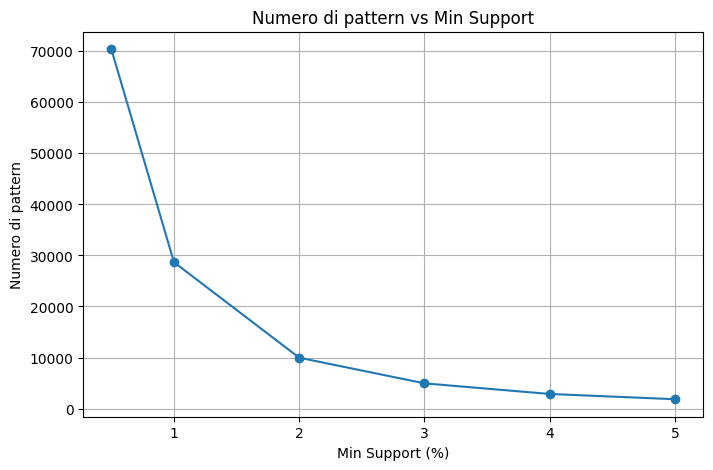


Top 10 pattern per min_support=0.5%:
Pattern: ('MinPlayers_disc=Few', 'ComAgeRec_disc=Teen'), Support: 49.236031927023944
Pattern: ('MaxPlayers_disc=Small', 'MinPlayers_disc=Few'), Support: 41.76510832383124
Pattern: ('MaxPlayers_disc=Small', 'ComAgeRec_disc=Teen'), Support: 37.8563283922463
Pattern: ('YearPublished_disc=2010s', 'ComAgeRec_disc=Teen'), Support: 36.574686431014825
Pattern: ('GameWeight_disc=Medium', 'ComAgeRec_disc=Teen'), Support: 34.184720638540476
Pattern: ('Rating_disc=Medium', 'ComAgeRec_disc=Teen'), Support: 33.683010262257696
Pattern: ('YearPublished_disc=2010s', 'MinPlayers_disc=Few'), Support: 31.931584948688712
Pattern: ('ComMaxPlaytime_disc=VeryShort', 'ComAgeRec_disc=Teen'), Support: 31.247434435575826
Pattern: ('ComMaxPlaytime_disc=VeryShort', 'MinPlayers_disc=Few'), Support: 30.285062713797036
Pattern: ('Rating_disc=Medium', 'MinPlayers_disc=Few'), Support: 29.88369441277081

Top 10 pattern per min_support=1%:
Pattern: ('MinPlayers_disc=Few', 'ComAgeRec_d

In [ ]:
from fim import apriori
import pandas as pd
import matplotlib.pyplot as plt

# Estrazione dei pattern con diversi min_support
supports = [0.5, 1, 2, 3, 4, 5]  # supporti in percentuale
results = []
all_itemsets = {}

for supp in supports:

    itemsets = apriori(
        X,
        target='s',    # estrazione frequent patterns
        supp=supp,
        zmin=2,        # pattern di almeno 2 item
        report='S'     # restituisce supporti
    )
    # Salvo tutti i pattern per analisi qualitative
    all_itemsets[supp] = itemsets
    results.append({
        "min_support_%": supp,
        "num_patterns": len(itemsets)
    })

# Analisi quantitativa
df_support_analysis = pd.DataFrame(results)
print(df_support_analysis)

# Grafico: numero di pattern vs supporto
plt.figure(figsize=(8,5))
plt.plot(df_support_analysis['min_support_%'], df_support_analysis['num_patterns'], marker='o')
plt.title('Numero di pattern vs Min Support')
plt.xlabel('Min Support (%)')
plt.ylabel('Numero di pattern')
plt.grid(True)
plt.show()

# Analisi qualitativa
# Esaminiamo i primi 10 pattern più frequenti per ciascun supporto
for supp in supports:
    print(f"\nTop 10 pattern per min_support={supp}%:")
    # ordina per supporto decrescente
    sorted_itemsets = sorted(all_itemsets[supp], key=lambda x: x[1], reverse=True)
    for pattern, support in sorted_itemsets[:10]:
        print(f"Pattern: {pattern}, Support: {support}")


ar extraction

In [ ]:
conf = 50
rules = apriori(X, target="r", supp=3, zmin=2, conf=conf, report="aScl")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)
rules_df.sort_values(by="lift", axis=0, ascending=False)

,consequent,antecedent,abs_support,%_support,confidence,lift
36,ComMinPlaytime_disc=Long,"(YearPublished_disc=1990s, ComMaxPlaytime_disc...",636,2.900798,0.965099,4.788366
1612,ComMaxPlaytime_disc=Long,"(ComAgeRec_disc=YoungAdult, ComMinPlaytime_dis...",630,2.873432,0.937500,4.782384
1608,ComMaxPlaytime_disc=Long,"(ComAgeRec_disc=YoungAdult, ComMinPlaytime_dis...",779,3.553022,0.929594,4.742055
1618,ComMaxPlaytime_disc=Long,"(ComAgeRec_disc=YoungAdult, ComMinPlaytime_dis...",850,3.876853,0.927948,4.733655
552,ComMinPlaytime_disc=Long,"(YearPublished_disc=<1990, ComMaxPlaytime_disc...",635,2.896237,0.949178,4.709374
...,...,...,...,...,...,...
13945,ComAgeRec_disc=Teen,"(NumOwned_disc=VeryHigh, GameWeight_disc=Heavy...",577,2.631699,0.500868,0.689448
4244,ComAgeRec_disc=Teen,"(ComMinPlaytime_disc=Long, GameWeight_disc=Hea...",661,3.014823,0.500758,0.689296
3315,ComAgeRec_disc=Teen,"(ComMaxPlaytime_disc=Long, ComMinPlaytime_disc...",715,3.261117,0.500700,0.689217
4295,ComAgeRec_disc=Teen,"(ComMinPlaytime_disc=Long, Rating_disc=Medium,...",462,2.107184,0.500542,0.688999


In [ ]:
print(f"Numero di regole generate: {len(rules_df)}")


Numero di regole generate: 22905


(array([2178., 2056., 2141., 1965., 1785., 1775., 1717., 1686., 1484.,
       1383., 1132.,  874.,  657.,  606.,  505.,  369.,  280.,  180.,
         98.,   34.]), array([0.5       , 0.52462073, 0.54924147, 0.5738622 , 0.59848293,
       0.62310367, 0.6477244 , 0.67234513, 0.69696587, 0.7215866 ,
       0.74620733, 0.77082807, 0.7954488 , 0.82006953, 0.84469027,
       0.869311  , 0.89393173, 0.91855247, 0.9431732 , 0.96779393,
       0.99241466]), <BarContainer object of 20 artists>)


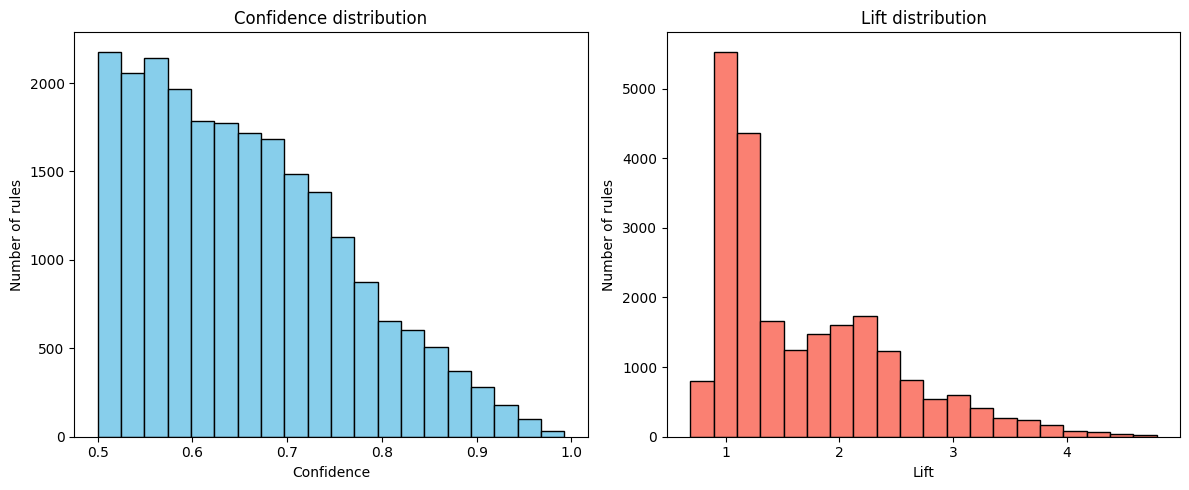

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
out = plt.hist(rules_df['confidence'], bins=20, color='skyblue', edgecolor='black')
print(out)
plt.title('Confidence distribution')
plt.xlabel('Confidence')
plt.ylabel('Number of rules')

plt.subplot(1,2,2)
plt.hist(rules_df['lift'], bins=20, color='salmon', edgecolor='black')
plt.title('Lift distribution')
plt.xlabel('Lift')
plt.ylabel('Number of rules')

plt.tight_layout()
plt.show()


regole sortate per lift con support > 1

In [ ]:
top_rules = (
    rules_df
    .query("`%_support` >= 1")   # esempio: almeno 1% di supporto
    .sort_values(by='lift', ascending=False)
    .head(10)
)

for _, row in top_rules.iterrows():
    print(
        f"Regola: {row['antecedent']} → {row['consequent']}, "
        f"Support: {row['%_support']:.2f}%, "
        f"Confidence: {row['confidence']:.2f}%, "
        f"Lift: {row['lift']:.2f}"
    )

Regola: ('YearPublished_disc=1990s', 'ComMaxPlaytime_disc=Long') → ComMinPlaytime_disc=Long, Support: 2.90%, Confidence: 0.97%, Lift: 4.79
Regola: ('ComAgeRec_disc=YoungAdult', 'ComMinPlaytime_disc=Long', 'Rating_disc=High', 'MaxPlayers_disc=Small') → ComMaxPlaytime_disc=Long, Support: 2.87%, Confidence: 0.94%, Lift: 4.78
Regola: ('ComAgeRec_disc=YoungAdult', 'ComMinPlaytime_disc=Long', 'Rating_disc=High', 'GameWeight_disc=Heavy') → ComMaxPlaytime_disc=Long, Support: 3.55%, Confidence: 0.93%, Lift: 4.74
Regola: ('ComAgeRec_disc=YoungAdult', 'ComMinPlaytime_disc=Long', 'Rating_disc=High') → ComMaxPlaytime_disc=Long, Support: 3.88%, Confidence: 0.93%, Lift: 4.73
Regola: ('YearPublished_disc=<1990', 'ComMaxPlaytime_disc=Long', 'MaxPlayers_disc=Small') → ComMinPlaytime_disc=Long, Support: 2.90%, Confidence: 0.95%, Lift: 4.71
Regola: ('ComAgeRec_disc=YoungAdult', 'ComMinPlaytime_disc=Long', 'GameWeight_disc=Heavy', 'MaxPlayers_disc=Small', 'MinPlayers_disc=Few') → ComMaxPlaytime_disc=Long, 

In [ ]:
top_rules = rules_df.head(10)
for idx, row in top_rules.iterrows():
    print(f"Regola: {row['antecedent']} → {row['consequent']}, "
          f"Support: {row['%_support']:.2f}%, Confidence: {row['confidence']:.2f}%, Lift: {row['lift']:.2f}")


Regola: ('YearPublished_disc=2020s', 'Rating_disc=High', 'MaxPlayers_disc=Small') → MinPlayers_disc=Solo, Support: 1.57%, Confidence: 0.50%, Lift: 2.93
Regola: ('YearPublished_disc=2020s', 'MinPlayers_disc=Solo') → Rating_disc=High, Support: 2.37%, Confidence: 0.74%, Lift: 3.24
Regola: ('YearPublished_disc=2020s', 'MinPlayers_disc=Solo') → MaxPlayers_disc=Small, Support: 2.06%, Confidence: 0.65%, Lift: 1.18
Regola: ('YearPublished_disc=2020s', 'MinPlayers_disc=Solo') → ComAgeRec_disc=Teen, Support: 2.55%, Confidence: 0.80%, Lift: 1.11
Regola: ('YearPublished_disc=2020s', 'Rating_disc=High', 'MaxPlayers_disc=Small') → NumWant_disc=VeryHigh, Support: 1.70%, Confidence: 0.55%, Lift: 2.19
Regola: ('YearPublished_disc=2020s', 'Rating_disc=High', 'ComAgeRec_disc=Teen') → NumWant_disc=VeryHigh, Support: 1.94%, Confidence: 0.52%, Lift: 2.08
Regola: ('YearPublished_disc=2020s', 'Rating_disc=High') → NumWant_disc=VeryHigh, Support: 2.51%, Confidence: 0.52%, Lift: 2.08
Regola: ('YearPublished_dis

Support = Rappresenta la frequenza con cui la regola appare nell’intero dataset.
Confidence = È la probabilità che il conseguente sia vero dato l’antecedente
Lift = Misura quanto la presenza dell’antecedente aumenta la probabilità del conseguente rispetto al caso casuale


Osservazioni sulle tue regole:

Le regole con consequente Rating_disc=High hanno lift tra 2.96 e 3.24: quindi sono regole forti.

Support è basso (~2-3%), quindi queste regole riguardano pochi giochi, ma sono significative per quei casi.

Confidence tra 0.68 e 0.74: discreta, conferma che l’antecedente è un buon indicatore del Rating alto.

In [ ]:
rules_df.head(10)

,consequent,antecedent,abs_support,%_support,confidence,lift
0,MinPlayers_disc=Solo,"(YearPublished_disc=2020s, Rating_disc=High, M...",344,1.568985,0.502924,2.926382
1,Rating_disc=High,"(YearPublished_disc=2020s, MinPlayers_disc=Solo)",519,2.367161,0.744620,3.241817
2,MaxPlayers_disc=Small,"(YearPublished_disc=2020s, MinPlayers_disc=Solo)",452,2.061574,0.648494,1.180425
3,ComAgeRec_disc=Teen,"(YearPublished_disc=2020s, MinPlayers_disc=Solo)",560,2.554162,0.803443,1.105945
4,NumWant_disc=VeryHigh,"(YearPublished_disc=2020s, Rating_disc=High, M...",373,1.701254,0.545322,2.189375
5,NumWant_disc=VeryHigh,"(YearPublished_disc=2020s, Rating_disc=High, C...",426,1.942987,0.518879,2.083214
6,NumWant_disc=VeryHigh,"(YearPublished_disc=2020s, Rating_disc=High)",551,2.513113,0.519321,2.084988
7,Rating_disc=High,"(YearPublished_disc=2020s, NumWeightVotes_disc...",368,1.678449,0.525714,2.288778
8,GameWeight_disc=Medium,"(YearPublished_disc=2020s, Rating_disc=High, C...",449,2.047891,0.546894,1.373814
9,Rating_disc=High,"(YearPublished_disc=2020s, GameWeight_disc=Med...",449,2.047891,0.680303,2.961804


##Classificazione con regoel

In [ ]:
rating_rules = rules_df[
    rules_df["consequent"].str.contains("Rating_disc")
].copy()

print("Numero regole per Rating:", len(rating_rules))
rating_rules.sort_values(by=["lift", "confidence"], ascending=False).tail(10)


Numero regole per Rating: 2123


,consequent,antecedent,abs_support,%_support,confidence,lift
14655,Rating_disc=Medium,"(NumOwned_disc=High, GameWeight_disc=Medium, M...",744,3.393387,0.500336,1.137482
13988,Rating_disc=Medium,"(NumOwned_disc=VeryHigh, ComMinPlaytime_disc=M...",754,3.438997,0.500332,1.137471
381,Rating_disc=Medium,"(ComAgeRec_disc=Child, ComMinPlaytime_disc=Ver...",382,1.742303,0.500000,1.136717
836,Rating_disc=Medium,"(MaxPlayers_disc=Large, NumWeightVotes_disc=Lo...",336,1.532497,0.500000,1.136717
5408,Rating_disc=Medium,"(NumWant_disc=Medium, ComMinPlaytime_disc=Very...",418,1.906499,0.500000,1.136717
9757,Rating_disc=Medium,"(ComMaxPlaytime_disc=Medium, NumOwned_disc=Ver...",336,1.532497,0.500000,1.136717
10922,Rating_disc=Medium,"(NumWeightVotes_disc=VeryHigh, NumWant_disc=Ve...",389,1.774230,0.500000,1.136717
11476,Rating_disc=Medium,"(NumWeightVotes_disc=VeryHigh, NumOwned_disc=V...",1380,6.294185,0.500000,1.136717
13062,Rating_disc=Medium,"(NumOwned_disc=Medium, ComMaxPlaytime_disc=Ver...",448,2.043330,0.500000,1.136717
14368,Rating_disc=Medium,"(NumOwned_disc=High, GameWeight_disc=Heavy, Co...",411,1.874572,0.500000,1.136717


In [ ]:
def predict_rating_from_rules(row, rating_rules):
    """
    row = riga del DataFrame X (una transazione)
    rating_rules = regole con Rating come consequente
    """
    items = set(row)

    candidates = []

    for _, r in rating_rules.iterrows():
        antecedent = set(r["antecedent"])

        # Corrected: Get the consequent string directly
        consequent_item_str = r["consequent"]

        # Ensure that the consequent item string contains '=' before splitting
        if '=' in consequent_item_str:
            rating = consequent_item_str.split("=")[1]
        else:
            # If a consequent doesn't have the expected 'key=value' format, skip this rule
            continue

        # Se l'antecedente è contenuto nel record
        if antecedent.issubset(items):
            conf = r["confidence"]
            lift = r["lift"]
            candidates.append((rating, conf, lift))

    if len(candidates) == 0:
        return "Unknown"

    # scegli la regola con confidence massima (e lift come tie-breaker)
    best = sorted(candidates, key=lambda x: (x[1], x[2]), reverse=True)[0]
    return best[0]

In [ ]:
predicted_ratings = [predict_rating_from_rules(row, rating_rules) for row in X]
df["Predicted_Rating"] = predicted_ratings


In [ ]:
df["True_Rating"] = df["Rating_disc"]


In [ ]:
df[["True_Rating", "Predicted_Rating"]].head()


,True_Rating,Predicted_Rating
0,Low,Medium
1,Medium,Medium
2,High,High
3,Low,Low
4,Medium,Low


In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(df["True_Rating"], df["Predicted_Rating"])
print("Accuracy:", acc)



Accuracy: 0.596533637400228


In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

labels = ["Low", "Medium", "High"]

cm = confusion_matrix(df["True_Rating"], df["Predicted_Rating"], labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

print(cm_df)


         Low  Medium  High
Low     5887    1037   321
Medium  3508    3750  2386
High     614     980  3442


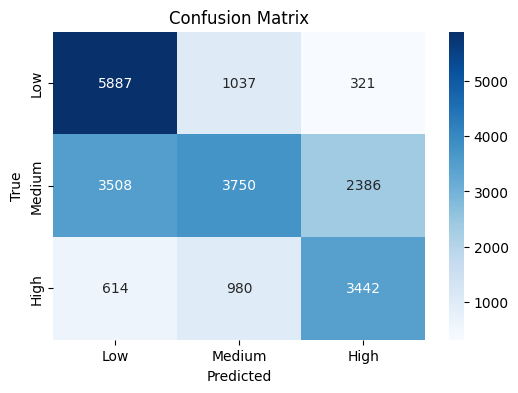

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

labels = ["Low", "Medium", "High"]

# Crea la confusion matrix
cm = confusion_matrix(df["True_Rating"], df["Predicted_Rating"], labels=labels)


cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot con seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
def generate_rules_with_conf_range(X, conf_values, supp=3, zmin=2):
    """
    X: lista transazioni one-hot
    conf_values: lista di valori di confidence da provare
    supp, zmin: parametri di supporto minimo e dimensione minima regole
    """
    results = {}

    for conf in conf_values:
        rules = apriori(
            X,
            target="r",
            supp=supp,
            zmin=zmin,
            conf=conf,
            report="aScl"
        )

        rules_df = pd.DataFrame(
            rules,
            columns=["consequent", "antecedent", "abs_support", "%_support", "confidence", "lift"]
        )

        # ordina per lift discendente
        rules_df = rules_df.sort_values(by=["lift", "confidence"], ascending=False)

        results[conf] = rules_df

        print(f"\nCONF = {conf}% → Regole generate: {len(rules_df)}")

    return results


In [ ]:
conf_values = [10, 20, 30, 40, 50, 60, 70, 80, 90]
all_rules = generate_rules_with_conf_range(X, conf_values)


CONF = 10% → Regole generate: 101628

CONF = 20% → Regole generate: 75520

CONF = 30% → Regole generate: 48344

CONF = 40% → Regole generate: 32203

CONF = 50% → Regole generate: 22905

CONF = 60% → Regole generate: 14447

CONF = 70% → Regole generate: 7418

CONF = 80% → Regole generate: 2612

CONF = 90% → Regole generate: 512


In [ ]:
all_rules[30].head()


,consequent,antecedent,abs_support,%_support,confidence,lift
3,YearPublished_disc=2020s,"(MinPlayers_disc=Solo, Rating_disc=High, ComAg...",405,1.847206,0.376045,5.195197
0,YearPublished_disc=2020s,"(MinPlayers_disc=Solo, Rating_disc=High, MaxPl...",255,1.163056,0.359155,4.961860
43,YearPublished_disc=2020s,"(Rating_disc=High, NumWeightVotes_disc=Low, Co...",323,1.473204,0.354167,4.892945
148,ComMinPlaytime_disc=Long,"(YearPublished_disc=1990s, ComMaxPlaytime_disc...",636,2.900798,0.965099,4.788366
4375,ComMaxPlaytime_disc=Long,"(ComAgeRec_disc=YoungAdult, ComMinPlaytime_dis...",630,2.873432,0.937500,4.782384


In [ ]:
summary = []

# Iterate through the items of the all_rules dictionary
# Each item is (conf_value, rules_dataframe)
for conf, df_rules in all_rules.items():
    summary.append({
        "min_confidence": conf,
        "num_rules": len(df_rules),
        "avg_lift": df_rules["lift"].mean() if not df_rules.empty else 0
    })

summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values("min_confidence")
summary_df

,min_confidence,num_rules,avg_lift
0,10,101628,1.220724
1,20,75520,1.356728
2,30,48344,1.497997
3,40,32203,1.593746
4,50,22905,1.690568
5,60,14447,1.797895
6,70,7418,1.940205
7,80,2612,2.205358
8,90,512,2.706585


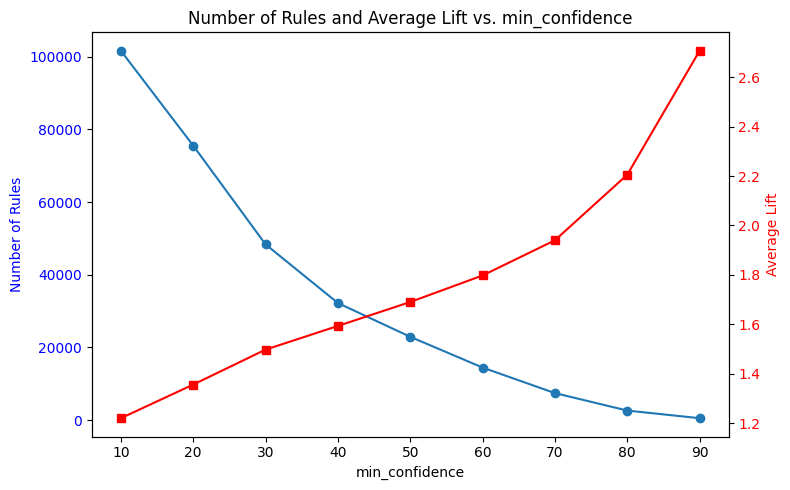

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8,5))

# Numero di regole (asse sinistro)
ax1.plot(summary_df["min_confidence"], summary_df["num_rules"], marker="o")
ax1.set_xlabel("min_confidence")
ax1.set_ylabel("Number of Rules", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Average lift (asse destro)
ax2 = ax1.twinx()
ax2.plot(summary_df["min_confidence"], summary_df["avg_lift"], marker="s", color="red")
ax2.set_ylabel("Average Lift", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Number of Rules and Average Lift vs. min_confidence")
plt.tight_layout()
plt.show()
